<a href="https://colab.research.google.com/github/wuchenyu38/Is20f/blob/master/chenyu/Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
from scipy.integrate import quad

$$
C_T(k)=\frac{e^{-\alpha k}}{\pi}\int_0^\infty e^{-ivk}\psi(v)dv
$$

In [58]:
class FTCall:
    def __init__(self, model):
        self.md = model
        
    #$\psi$ function for carr-madan method
    def psi(self, w, T, alpha):
        o1 = np.exp(-self.md.r*T)
        o1 = o1*self.md.charfun(T, w - (alpha+1)*1j)
        o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
        return o1/o2
    
    #carr-madan method with damping
    def price_cm(self, K, T, alpha = 1.5):
        k = np.log(K)
        integrand = lambda w: (np.exp(-1j*w*k)*self.psi(w, T, alpha)).real
        integral = quad(integrand, 0, np.inf)[0]
        return np.exp(-alpha*k)/np.pi*integral

$$
\psi_T(v)=\frac{e^{-rT}\Phi_T(v-(\alpha+1)i)}{\alpha^2+\alpha-v^2+i(2\alpha+1)v}
$$

$$
\phi_T(u)=[S_0e^{(r+\omega)T]}]^{iu}(1-i\theta vu+\frac{1}{2}\sigma^2 u^2v)^{-\frac{T}{v}}
$$

In [59]:
class VG:
    def __init__(self, S0, r, sigma, theta, v):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.theta = theta
        self.v = v
        
    #characteristic function for $ln S_T$
    def charfun(self, T, u):
        omega = (1/self.v)*np.log(1-self.theta*self.v-0.5*self.sigma**2*self.v)
        phi = (self.S0*np.exp((self.r+omega)*T))**(1j*u)*(1-1j*self.theta*self.v*u+1/2*self.sigma**2*u**2*self.v)**(-T/self.v)
        return phi

In [60]:
%%time
vg = VG(100, 0.0475, 0.2, 3, 0.061)
ftc = FTCall(vg)
ans = ftc.price_cm(110, 1, alpha = 1.5)
print(
      f'VG FT price by carr-madan is \n >> {ans}'
      )

VG FT price by carr-madan is 
 >> 31.328700593999912
CPU times: user 6 ms, sys: 0 ns, total: 6 ms
Wall time: 6.65 ms


In [61]:
def charfun(u):
    T = 1
    r = 0.0475
    theta = 3
    S0 = 100
    sigma = 0.2
    v = 0.061
    omega = (1/v)*np.log(1-theta*v-0.5*sigma**2*v)
    phi = (S0*np.exp((r+omega)*T))**(1j*u)*(1-1j*theta*v*u+1/2*sigma**2*u**2*v)**(-T/v)
    return phi

In [62]:
def SimpsonW(N,eta):
    delt = np.zeros(N, dtype=np.float)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = eta*(3 + (-1) ** j - delt) / 3
    return SimpsonW

In [63]:
def psi(w, T, alpha, r):
    o1 = np.exp(-r*T)
    o1 = o1*charfun(w - (alpha+1)*1j)
    o2 = alpha**2+alpha-w**2+1j*(2*alpha+1.)*w
    return o1/o2

In [64]:
def VG_NumpyFFT(S0, K, T):
    k = np.log(K)
    x0 = np.log(S0)
    N =2**10
    alpha=1.5
    
    eta=0.15
    lambda_ = 2 * np.pi / (N *eta)
    beta=x0-lambda_*N/2
    km=np.asarray([beta+i*lambda_ for i in range(N)])
    W=SimpsonW(N,eta)
    v=np.asarray([i*eta for i in range(N)])
    Psi=np.asarray([psi(vj, T, alpha, 0)  for vj in v])
    FFTFunc=Psi*np.exp(-1j*beta*v)*W
    
    
    y=np.fft.fft(FFTFunc).real
    
    
    cT=np.exp(-alpha*km)*y/np.pi
    return cT

In [65]:
%%time
print(
      f'VG FFT price by carr-madan is \n >> {VG_NumpyFFT(100, 110, 1)}'
      )

VG FFT price by carr-madan is 
 >> [-5.27077358e+14 -5.07605143e+14 -4.88438670e+14 ... -3.02819985e-13
 -2.92374902e-13 -2.82051039e-13]
CPU times: user 37 ms, sys: 12 µs, total: 37 ms
Wall time: 40.7 ms


In [66]:
S0 = 100.0  # index level
N =2**10 
eta=0.15
lambda_ = 2 * np.pi / (N *eta)
x0 = np.log(S0)
beta=x0-lambda_*N/2
k=np.asarray([np.e**(beta+lambda_*n) for n in range(N)])

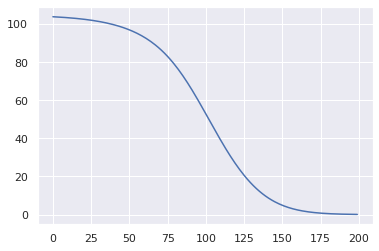

In [67]:
import matplotlib.pyplot as plt
plt.plot(VG_NumpyFFT(100, 110, 1)[400:600]) 
plt.show()

In [68]:
#Verification based on the book (Analytical Method)
Verify_VG = VG(100, 0.1, 0.12, -0.14, 0.2)
Verify_Call = FTCall(Verify_VG)
Kv = 10
call_option_price = [] 
for i in range (10):
  call_option_price.append(Verify_Call.price_cm(Kv, 1/12, alpha = 1.5)) 
  Kv = Kv + 10

call_option_price

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  app.launch_new_instance()


[90.08409184340738,
 80.1826364596626,
 70.25883894438714,
 60.330122095468134,
 50.41558217226299,
 40.49808070615871,
 30.58130804666516,
 20.670417652778628,
 10.828867975353846,
 1.8149982036650307]

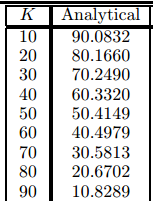

In [69]:
True_value = [90.0832, 80.1660, 70.2490, 60.3320, 50.4149, 40.4979, 30.5813, 20.6702, 10.8289]

In [70]:
True_value

[90.0832, 80.166, 70.249, 60.332, 50.4149, 40.4979, 30.5813, 20.6702, 10.8289]

In [71]:
percentage = []
for i in range(9):
  error = abs(True_value[i]-call_option_price[i])
  percentage.append(error/True_value[i])

sum(percentage)/9

4.670590949722221e-05

In [72]:
from scipy import optimize

In [73]:
def g1(params, M, K):
    sigma, theta, v = params
    market_price = M
    strike_price = K
    VG2 = VG(3638.35, 0.0088, sigma, theta, v)
    ftc2 = FTCall(VG2)
    ans = ftc2.price_cm(strike_price, 1/12, alpha = 1.5)
    return abs(market_price - ans)

guess_g1=[0.1, 0.1, 0.1]

minimum_SPX= optimize.fmin(g1,guess_g1,args=(91, 3600, ), maxfun=400000000000,maxiter=400000000000,ftol=1e-20,xtol=1e-20)

sigma, theta, v = minimum_SPX


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 160
         Function evaluations: 334


In [74]:
Stirke = [3600, 3605, 3610, 3615, 3620, 3625, 3630, 3635, 3640, 3645, 3650, 3655, 3660, 3665, 3670, 3675, 3680, 3685, 3690, 3695, 3700]
Option = [91, 87.5, 84.1, 80, 77.6, 74.1, 71.4, 68.4, 65.4, 62.5, 59.7, 57, 54.3, 51.4, 49.2, 46.9, 44.4, 42.2, 40, 37.8, 35.7]

In [75]:
sigma_list = []
theta_list = []
v_list = []
for i in range(21):
  K = Stirke[i]
  M = Option[i]
  guess_g1=[0.1, 0.1, 0.1]
  minimum_SPX= optimize.fmin(g1,guess_g1,args=(M, K, ), maxfun=400000000000,maxiter=400000000000,ftol=1e-12,xtol=1e-12)
  sigma, theta, v = minimum_SPX
  sigma_list.append(sigma)
  theta_list.append(theta)
  v_list.append(v)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 268
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 138
         Function evaluations: 274
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 135
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 265
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 138
         Function evaluations: 275
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 266
Optimization termina

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  app.launch_new_instance()


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 130
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 130
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 268
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 264
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 131
         Function evaluations: 262
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 131
         Function evaluations: 263
Optimization termina

In [76]:
price_b = []
for i in range(21):
  sigma_b = sigma_list[i]
  theta_b = theta_list[i]
  v_b = v_list[i]
  strike_b = Stirke[i]
  vg_b = VG(3638.35, 0.0088, sigma_b, theta_b, v_b)
  ftc_b = FTCall(vg_b)
  ans_b = ftc_b.price_cm(strike_b, 1/12, alpha = 1.5)
  price_b.append(ans_b)

In [77]:
price_b

[90.99999999999989,
 87.5000000000003,
 84.09999999999889,
 79.99999999999999,
 77.60000000000035,
 74.09999999999988,
 71.39999999999975,
 68.39999999999712,
 65.40000000000005,
 62.499999999999936,
 59.69999999999994,
 57.000000000000064,
 54.29999999999982,
 51.399999999999814,
 49.19999999999956,
 46.90000000000043,
 44.39999999999965,
 42.200000000000074,
 40.00000000000028,
 37.80000000000022,
 35.69999999999995]

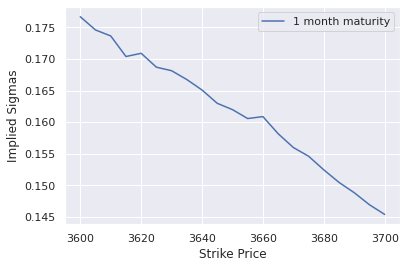

In [78]:
plt.plot(Stirke, sigma_list, label = '1 month maturity')
plt.ylabel('Implied Sigmas')
plt.xlabel('Strike Price')
plt.legend();

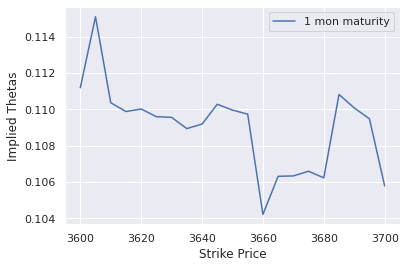

In [79]:
plt.plot(Stirke, theta_list, label = '1 mon maturity')
plt.ylabel('Implied Thetas')
plt.xlabel('Strike Price')
plt.legend();

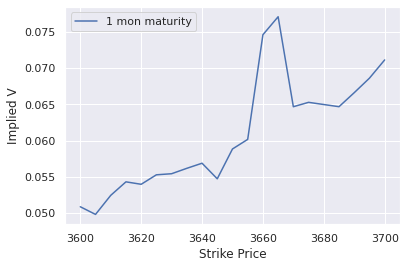

In [80]:
plt.plot(Stirke, v_list, label = '1 mon maturity')
plt.ylabel('Implied V')
plt.xlabel('Strike Price')
plt.legend();

In [81]:
import seaborn as sns; sns.set()

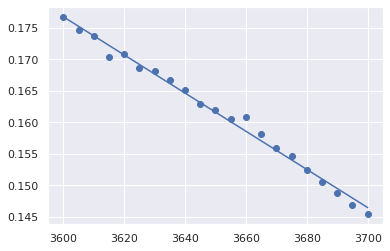

In [82]:
from sklearn.linear_model import LinearRegression
model_sigma = LinearRegression(fit_intercept=True)

model_sigma.fit(np.array(Stirke).reshape(-1,1), np.array(sigma_list).reshape(-1, 1))

xfit_sigma = np.linspace(3600, 3700, 1000)
yfit_sigma = model_sigma.predict(xfit_sigma[:, np.newaxis])

plt.scatter(Stirke, sigma_list)
plt.plot(xfit_sigma, yfit_sigma);

In [83]:
print("Model slope:    ", model_sigma.coef_[0])
print("Model intercept:", model_sigma.intercept_)

Model slope:     [-0.00030317]
Model intercept: [1.26819529]


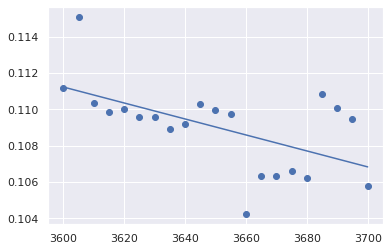

In [84]:
from sklearn.linear_model import LinearRegression
model_theta = LinearRegression(fit_intercept=True)

model_theta.fit(np.array(Stirke).reshape(-1,1), np.array(theta_list).reshape(-1, 1))

xfit_theta = np.linspace(3600, 3700, 1000)
yfit_theta = model_theta.predict(xfit_theta[:, np.newaxis])

plt.scatter(Stirke, theta_list)
plt.plot(xfit_theta, yfit_theta);

In [85]:
print("Model slope:    ", model_theta.coef_[0])
print("Model intercept:", model_theta.intercept_)

Model slope:     [-4.402324e-05]
Model intercept: [0.26971759]


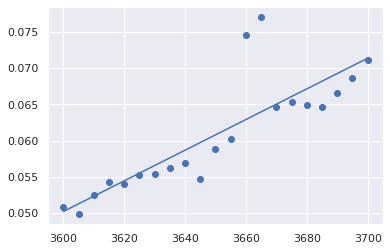

In [86]:
from sklearn.linear_model import LinearRegression
model_v = LinearRegression(fit_intercept=True)

model_v.fit(np.array(Stirke).reshape(-1,1), np.array(v_list).reshape(-1, 1))

xfit_v = np.linspace(3600, 3700, 1000)
yfit_v = model_v.predict(xfit_v[:, np.newaxis])

plt.scatter(Stirke, v_list)
plt.plot(xfit_v, yfit_v);

In [87]:
print("Model slope:    ", model_v.coef_[0])
print("Model intercept:", model_v.intercept_)

Model slope:     [0.00021135]
Model intercept: [-0.71065802]


In [88]:
price_r = []
for i in range(21):
  sigma_r = -0.00030317*Stirke[i]+1.26819529
  theta_r = -4.402324e-05*Stirke[i]+0.26971759
  v_r = 0.00021135*Stirke[i] - 0.71065802
  strike_r = Stirke[i]
  vg_r = VG(3638.35, 0.0088, sigma_r, theta_r, v_r)
  ftc_r = FTCall(vg_r)
  ans_r = ftc_r.price_cm(strike_r, 1/12, alpha = 1.5)
  price_r.append(ans_r)

In [89]:
price_r

[91.09293284681223,
 87.5882315675865,
 84.15167817456314,
 80.78649090410332,
 77.4956247400032,
 74.2817346155779,
 71.14714881949313,
 68.09385282121558,
 65.12348185244896,
 62.23732158656008,
 59.43631654482045,
 56.72108118462992,
 54.09191680543237,
 51.54883010022657,
 49.09155454081401,
 46.71957179121101,
 44.43213559653015,
 42.228292406107784,
 40.106905240334335,
 38.06667420799444,
 36.10615685045829]

In [99]:
sum(abs(np.array(price_r)-np.array(Option))/np.array(Option))/21

0.0036813629003776974

In [92]:
sum

[90.0832, 80.166, 70.249, 60.332, 50.4149, 40.4979, 30.5813, 20.6702, 10.8289]